In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy import linalg
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
import random
import time
import copy
from collections import defaultdict, Counter

from typing import List
import pickle
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [2]:
def get_TPR(y_pred, y_true, p2i, i2p, y_p_test):
    gender = np.where(y_p_test == 1, 'f', 'm')
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        if prof_total_m > 0 and prof_total_f > 0:
            tpr_m = (good_m) / prof_total_m
            tpr_f = (good_f) / prof_total_f

            tprs[profession]["m"] = tpr_m
            tprs[profession]["f"] = tpr_f
            tprs_ratio.append(0)
            tprs_change[profession] = tpr_f - tpr_m
        else:
            print(f"profession {profession} missed in tpr-calc:\n\
                  number of {profession} male in test set {prof_total_m}\n\
                  number of {profession} female in test set {prof_total_f}\n\n")
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
# def save_vecs_and_words(vecs, words):
#     def to_string(arr):
#         return "\t".join([str(x) for x in arr])
    
#     with open("vecs.txt", "w") as f:
#         for v in vecs:
#             assert len(v) == 300
#             f.write(to_string(v) + "\n")
    
#     with open("labels.txt", "w") as f:
#             f.write("Profession\n")
#             for w in words:
#                 f.write(w + "\n")

### Load data

In [3]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

### Load original data (train.pickle etc.) and pre-calculated BERT CLS states ("train_cls.npy" etc.)

In [4]:
train = load_dataset("../data/biasbios/train.pickle")
dev = load_dataset("../data/biasbios/dev.pickle")
test = load_dataset("../data/biasbios/test.pickle")
counter = count_profs_and_gender(train+dev+test)
prof2fem = dict()

f,m = 0., 0.
for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.44541700643683746
{'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}


In [5]:
saved_dataset = np.load(f"../data/saved_models/fair_biography_prof_gender/FastText/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

x_test = saved_dataset['x_test']
y_p_test = saved_dataset['y_p_test']
y_m_test = saved_dataset['y_m_test']

y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

In [6]:
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")

# Option 1: Train the model from scratch

In [ ]:
# N = 15000
# N_test = 5000
N = 4000
N_test = 1000

ratio = "FastText"

# kernel_fn = "rbf"
# kernel_coef = 0.1
kernel_fn = "poly"
kernel_coef = 2

assert x_train[:N, :].shape[1] == x_train[:N, :].shape[1]

K_y = y_p_train_2d[:N, :] @ y_p_train_2d[:N, :].T
if kernel_fn == "linear":
    K_x = x_train[:N, :] @ x_train[:N, :].T
    K_x_test_tr = x_test[:N_test, :] @ x_train[:N, :].T
elif kernel_fn == "rbf":
    K_x = rbf_kernel(x_train[:N, :], x_train[:N, :], kernel_coef)
    K_x_test_tr = rbf_kernel(x_test[:N_test, :], x_train[:N, :], kernel_coef)
elif kernel_fn == "poly":
    n_features = x_train[:N, :].shape[1]
    K_x = rbf_kernel(x_train[:N, :], x_train[:N, :], kernel_coef)
    K_x_test_tr = polynomial_kernel(x_test[:N_test, :], x_train[:N, :], degree = kernel_coef, gamma = n_features, coef0=1)

print(f"K_x.shape, K_x_test_tr.shape {K_x.shape, K_x_test_tr.shape}")
eigenval, W = np.linalg.eig(np.dot(K_y, K_x))
order = np.argsort(np.abs(np.real(eigenval)))
W = W[:, order]
W = np.real(W)
A = np.concatenate((K_x, K_x_test_tr), axis=0)
u, s, vh = np.linalg.svd(A)
s = s**(0.5)
s = np.diag(s)
print(f"A.shape, u.shape, s.shape, vh.shape {A.shape, u.shape, s.shape, vh.shape}")

K_x_sqrt_all = np.dot(np.dot(u[:, :s.shape[0]], s), vh[:s.shape[1], :])
K_x_sqrt2 = K_x_sqrt_all[:N, :]
K_x_test_sqrt2 = K_x_sqrt_all[N:, :]
print(f"K_x.shape, K_x_test_sqrt2.shape, K_x_sqrt_all.shape {K_x.shape, K_x_test_sqrt2.shape, K_x_sqrt_all.shape}")

remove_eigen_num = 2
U_proj_ker = linalg.null_space((K_x_sqrt2 @ W[:, :remove_eigen_num]).T)
debiased_x_train = np.dot(K_x_sqrt2, U_proj_ker)
debiased_x_test = np.dot(K_x_test_sqrt2, U_proj_ker)
print(f"debiased_x_train.shape, debiased_x_test.shape {debiased_x_train.shape, debiased_x_test.shape}")


In [ ]:
random.seed(0)
np.random.seed(0)

clf_original = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)
                         

clf_original.fit(x_train[:N, :], y_m_train[:N])
print(f"Score of profession classifier on original(biased) dataset \n{clf_original.score(x_test[:N_test, :], y_m_test[:N_test])}")


In [ ]:
clf_debiased = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)

clf_debiased.fit(debiased_x_train, y_m_train[:N])
print(f"Score of profession classifier on debiased dataset \n{clf_debiased.score(debiased_x_test, y_m_test[:N_test])}")


In [ ]:
y_pred_before = clf_original.predict(x_test[:N_test])
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_m_test[:N_test], p2i, i2p, y_p_test[:N_test])
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)

y_pred_after = clf_debiased.predict(debiased_x_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_m_test[:N_test], p2i, i2p, y_p_test[:N_test])
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

# np.savez(f"../../data/saved_models/fair_biography_prof_gender/{ratio}/cleaned_Train{N}_Test{N_test}.npz", debiased_x_train = debiased_x_train, debiased_x_test = debiased_x_test)


# Option 2: load directly

## Train and save the model by src/ksal/ksal.py 

Then load it to the notebook

In [7]:
def tpr_exp(x_test, debiased_x_train, y_m_train, debiased_x_test, y_m_test, y_p_test, N_test, p2i, i2p, clf_original):
    y_p_test_string = np.where(y_p_test == 1, 'f', 'm')

    y_pred_before = clf_original.predict(x_test[:N_test])
    tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_m_test[:N_test], p2i, i2p, y_p_test[:N_test])
    similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)

    clf_debiased = LogisticRegression(warm_start = True, penalty = 'l2',
                             solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                             verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)

    clf_debiased.fit(debiased_x_train, y_m_train[:N])
    print(f"\n\n\n================================================\
                \nSCORE: of profession classifier on debiased dataset\
                \n{clf_debiased.score(debiased_x_test, y_m_test[:N_test])}\
                \n================================================\n\n\n")

    y_pred_after = clf_debiased.predict(debiased_x_test)
    tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_m_test[:N_test], p2i, i2p, y_p_test[:N_test])
    similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

    change_vals_before = np.array(list((tprs_change_before.values())))
    change_vals_after = np.array(list(tprs_change_after.values()))

    print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))


In [8]:
N = 15000
N_test = 5000
ratio = "FastText"

In [9]:
random.seed(0)
np.random.seed(0)

clf_original = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)
                         

clf_original.fit(x_train[:N, :], y_m_train[:N])
print(f"Score of profession classifier on original(biased) dataset \n{clf_original.score(x_test[:N_test, :], y_m_test[:N_test])}")


[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 5 seconds


/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:    5.4s finished


Score of profession classifier on original(biased) dataset 
0.7022


# 1. Linear Kernel

In [12]:
kernel_fn = "linear"
kernel_coef = 0

saved_model = np.load(f"../data/saved_models/fair_biography_prof_gender/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']

In [ ]:
# Removal 0 BERT Linear
tpr_exp(x_test, debiased_x_train_0, y_m_train, debiased_x_test_0, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

In [ ]:
# Removal 1 BERT Linear
tpr_exp(x_test, debiased_x_train_1, y_m_train, debiased_x_test_1, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.773655072810786; p-value: 6.29340039229481e-05


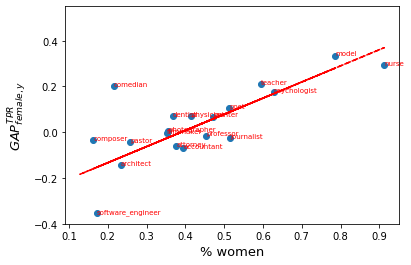

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 298 seconds



SCORE: of profession classifier on debiased dataset                
0.6974                





/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  5.0min finished


profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.28151941939644465; p-value: 0.21635439221736918


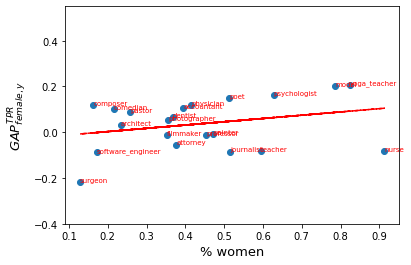

rms-diff before: 0.18337572303336608; rms-diff after: 0.11473460987575866


In [13]:
# Removal 2 BERT Linear
tpr_exp(x_test, debiased_x_train_2, y_m_train, debiased_x_test_2, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

# 2. RBF kernel at gamma = 0.1

In [14]:
kernel_fn = "rbf"
kernel_coef = 0.1

saved_model = np.load(f"../data/saved_models/fair_biography_prof_gender/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']

In [ ]:
# Removal 0 BERT RBF at gamma = 0.1
tpr_exp(x_test, debiased_x_train_0, y_m_train, debiased_x_test_0, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

In [ ]:
# Removal 1 BERT RBF at gamma = 0.1
tpr_exp(x_test, debiased_x_train_1, y_m_train, debiased_x_test_1, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.773655072810786; p-value: 6.29340039229481e-05


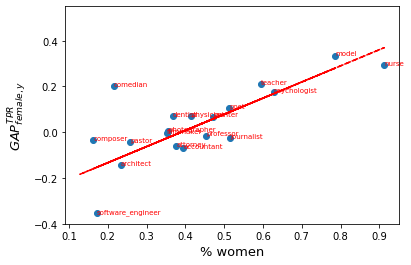

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 287 seconds



SCORE: of profession classifier on debiased dataset                
0.1372                





/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  4.8min finished


profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.450143871049959; p-value: 0.04059786566020312


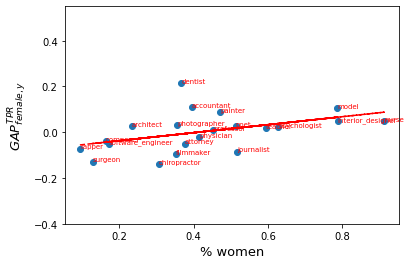

rms-diff before: 0.18337572303336608; rms-diff after: 0.08420485250044037


In [15]:
# Removal 2 BERT RBF at gamma = 0.1
tpr_exp(x_test, debiased_x_train_2, y_m_train, debiased_x_test_2, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

# 3. Polynomial kernel at degree=2

In [10]:
kernel_fn = "poly"
kernel_coef = 2

saved_model = np.load(f"../data/saved_models/fair_biography_prof_gender/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']

profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.773655072810786; p-value: 6.29340039229481e-05


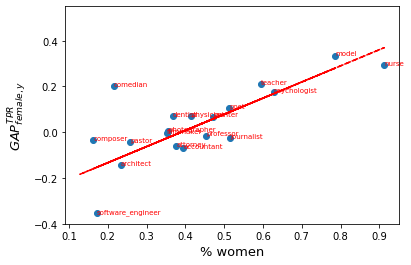

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 298 seconds



SCORE: of profession classifier on debiased dataset                
0.4952                





/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  5.0min finished


Correlation: 0.576632539140049; p-value: 0.08098230117672431


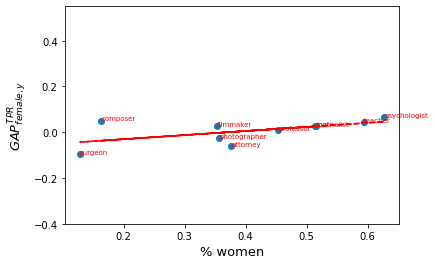

rms-diff before: 0.18337572303336608; rms-diff after: 0.04961962564035084


In [11]:
# Removal 0 BERT Poly 2
tpr_exp(x_test, debiased_x_train_0, y_m_train, debiased_x_test_0, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.773655072810786; p-value: 6.29340039229481e-05


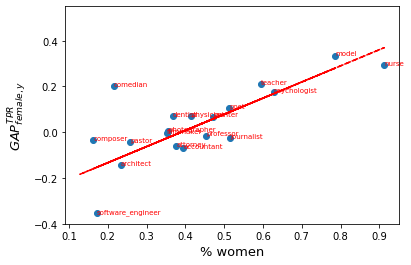

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 301 seconds



SCORE: of profession classifier on debiased dataset                
0.5806                





/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  5.0min finished


Correlation: 0.3789776883508932; p-value: 0.14772867602704037


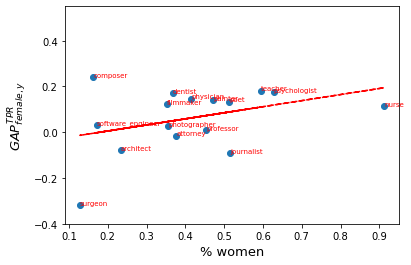

rms-diff before: 0.18337572303336608; rms-diff after: 0.1492207928515152


In [12]:
# Removal 1 BERT Poly 2
tpr_exp(x_test, debiased_x_train_1, y_m_train, debiased_x_test_1, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)

profession dietitian missed in tpr-calc:
                  number of dietitian male in test set 0
                  number of dietitian female in test set 59


Correlation: 0.773655072810786; p-value: 6.29340039229481e-05


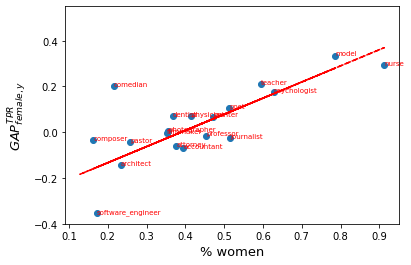

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 296 seconds


/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  4.9min finished





SCORE: of profession classifier on debiased dataset                
0.5762                



Correlation: 0.08446044696320024; p-value: 0.7472326984514821


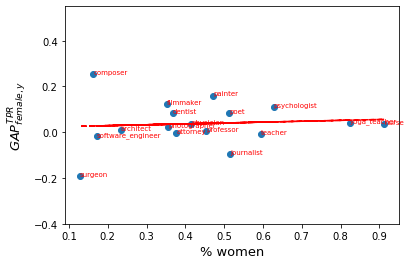

rms-diff before: 0.18337572303336608; rms-diff after: 0.10341280718742507


In [13]:
# Removal 2 BERT Poly 2
tpr_exp(x_test, debiased_x_train_2, y_m_train, debiased_x_test_2, y_m_test, \
        y_p_test, N_test, p2i, i2p, clf_original)